# Comparison of Class Histogram Techniques - Selectivity

In this notebook, we compare three methods of producing class histograms of a convolutional layer's kernels. The goal is to identify which one allows us to easily identify kernels that can distinguish different classes and produce meaningful projections using the class histograms as high-dimensional vectors.

The three methods are:
* V1: One histogram per kernel, with each bin measuring the number of images from a particular class that had at least one positively valued pixel in the output activation.
* V2: One histogram per kernel, with each bin measuring the total number of positively valued pixels in the output activation from all images of that class.
* V3: One histogram per output pixel, with each bin measuring the total number of images from a particular class activating a positive value on that pixel.

In all scenarios, we only consider images that were correctly labeled by the model.

In this experiment, we use selectivity values instead of entropy values to evaluate the separability of class histograms.

In [1]:
import numpy as np
import random

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm

from matplotlib.colorbar import ColorbarBase

from keras.datasets import cifar10
from keras.models import Sequential, load_model
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense
from keras.utils import np_utils
from keras.optimizers import SGD

from sklearn.manifold import TSNE
from sklearn.cluster import KMeans

from mpl_toolkits.axes_grid1 import make_axes_locatable

Using TensorFlow backend.


In [2]:
# Set random seed for reproducibility.
np.random.seed(0)
random.seed(0)

# Download CIFAR dataset.
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
 
# Normalize images.
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255
 
# One hot code labels.
num_classes = np.unique(y_train).shape[0]
y_train = np_utils.to_categorical(y_train, num_classes)
y_test = np_utils.to_categorical(y_test, num_classes)

# Shape of each observation.
elem_shape = x_train.shape[1:]

# Dataset labels.
labels = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

## Model

In this experiment, we use a model with 6 conv layers, achieving about 80% test set accuracy. We test each class histogram technique in both the first and last convolutional layer, so we can discover if the class histograms behave differently in deeper layers or not.

In [3]:
# Load pre-trained model.
model = load_model('models/model7.49.h5')

# Display model architecture.
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_67 (Conv2D)           (None, 32, 32, 64)        1792      
_________________________________________________________________
conv2d_68 (Conv2D)           (None, 32, 32, 64)        36928     
_________________________________________________________________
max_pooling2d_37 (MaxPooling (None, 16, 16, 64)        0         
_________________________________________________________________
dropout_54 (Dropout)         (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_69 (Conv2D)           (None, 16, 16, 64)        36928     
_________________________________________________________________
conv2d_70 (Conv2D)           (None, 16, 16, 64)        36928     
_________________________________________________________________
max_pooling2d_38 (MaxPooling (None, 8, 8, 64)          0         
__________

In [4]:
# Get predictions for the train set.
p_labels = np.argmax(model.predict(x_train), axis=1)
t_labels = np.argmax(y_train, axis=1)

# Check accuracy.
scores = model.evaluate(x_test, y_test, verbose=2)
print("Accuracy: %.2f%%" % (scores[1]*100))

Accuracy: 80.54%


## Class Histograms - V1

One histogram per kernel, with each bin measuring the number of images from a particular class that had at least one positively valued pixel in the output activation.

### 1st Layer

In [20]:
# Calculate class histograms of each of the layer's kernels.
histograms, selectivity = class_histogram_conv2d_v1(model, 0, x_train, t_labels, p_labels, num_classes)

In [21]:
# Calculate the activation matrix of each training element.
actv_matrix = activation_matrix_conv2d(model, 0, x_train, t_labels, p_labels, num_classes)    

In [22]:
# Calculate which neurons are off the limits defined by the selectivity thresholds.
selec_thresholds = check_selectivity_threshold(selectivity)

# Get the selectivity value of each kernel.
selectivity_values = get_kernel_selectivity_value(selectivity)

In [23]:
# Get the number of elements in the training set activating positive values on each kernel.
activations = layer_activation_number(actv_matrix, t_labels, p_labels, num_classes)

In [26]:
# Project the layer's class histograms to bidimensional space.
projection, divergence = project_histogram(histograms, p=20)
print(projection.shape, divergence)

(64, 2) 0.3500947654247284


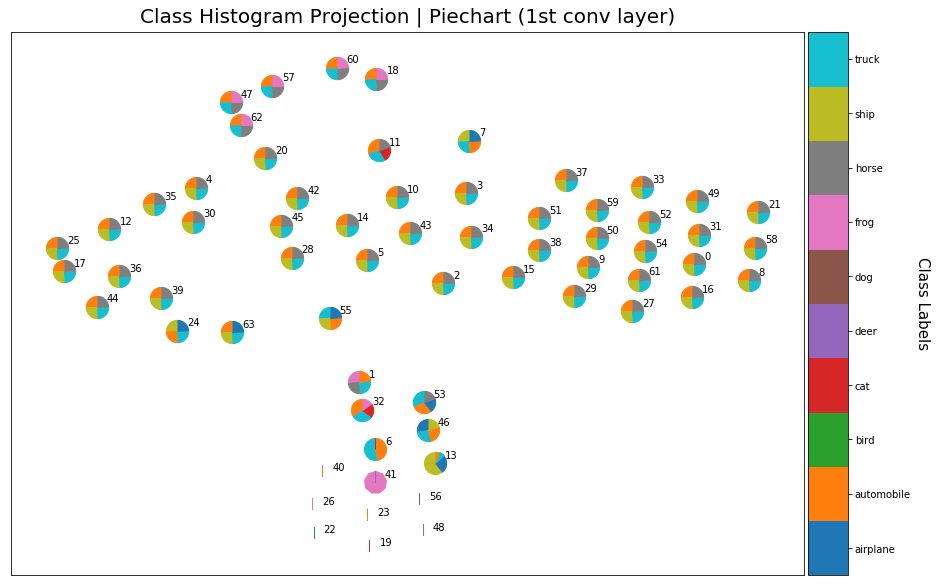

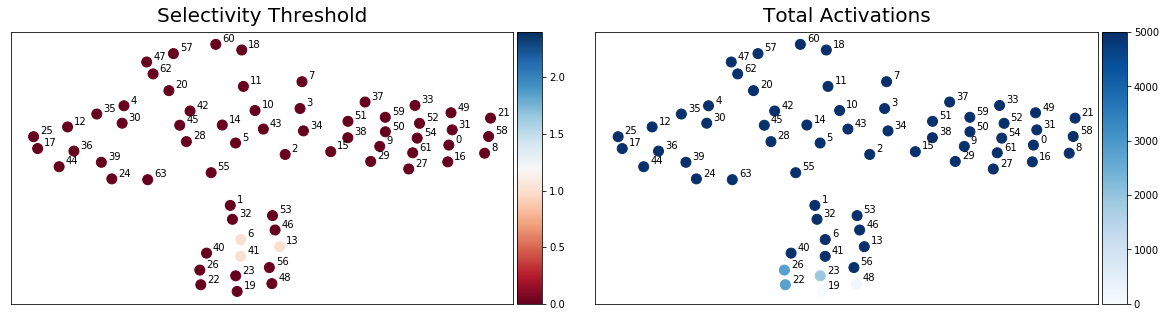

In [27]:
# Plot the class histogram projection using piecharts to display the 4 most predominant classes.
plot_projection_piechart(projection, histograms, 4, labels, '1st conv', 2.5, 500)

# Plot the same projection using entropy and total activations to color datapoints.
plot_auxiliar_projection(projection, selec_thresholds, activations, labels, 2.5)

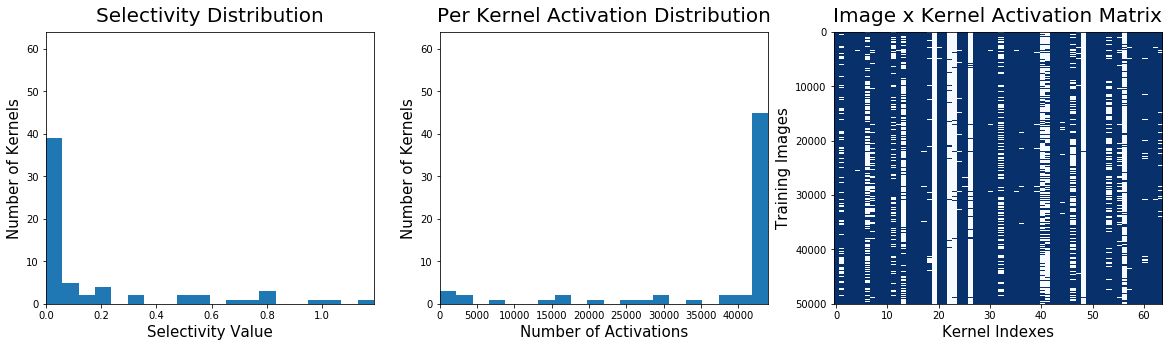

In [28]:
# Plot auxiliar histograms.
plot_auxiliar_visualizations(selectivity_values, activations, actv_matrix)

In [29]:
# Number of training images which do not activate in any kernel.
unactivated_elements_size(actv_matrix)

0

* Most kernels have no predominant class, with few exceptions.
* Around 2/3 of the kernels have very small selectivity, although the other 1/3 is very distributed.
* The majority of kernels activate for almost the entire training set.
* However, there is a significant number of kernels activating for fewer images.
* Every image in the training set activates in at least one kernel.

### 6th Layer

In [30]:
# Calculate class histograms of each of the layer's kernels.
histograms, selectivity = class_histogram_conv2d_v1(model, 9, x_train, t_labels, p_labels, num_classes)

In [31]:
# Calculate the activation matrix of each training element.
actv_matrix = activation_matrix_conv2d(model, 9, x_train, t_labels, p_labels, num_classes)    

In [32]:
# Calculate which neurons are off the limits defined by the selectivity thresholds.
selec_thresholds = check_selectivity_threshold(selectivity)

# Get the selectivity value of each kernel.
selectivity_values = get_kernel_selectivity_value(selectivity)

In [33]:
# Get the number of elements in the training set activating positive values on each kernel.
activations = layer_activation_number(actv_matrix, t_labels, p_labels, num_classes)

In [34]:
# Project the layer's class histograms to bidimensional space.
projection, divergence = project_histogram(histograms, p=20)
print(projection.shape, divergence)

(64, 2) 0.3371519148349762


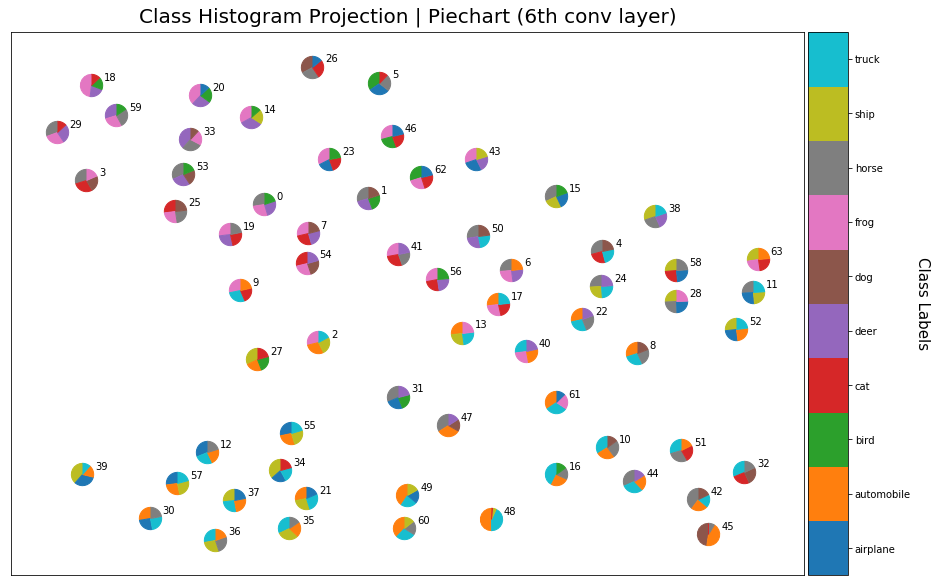

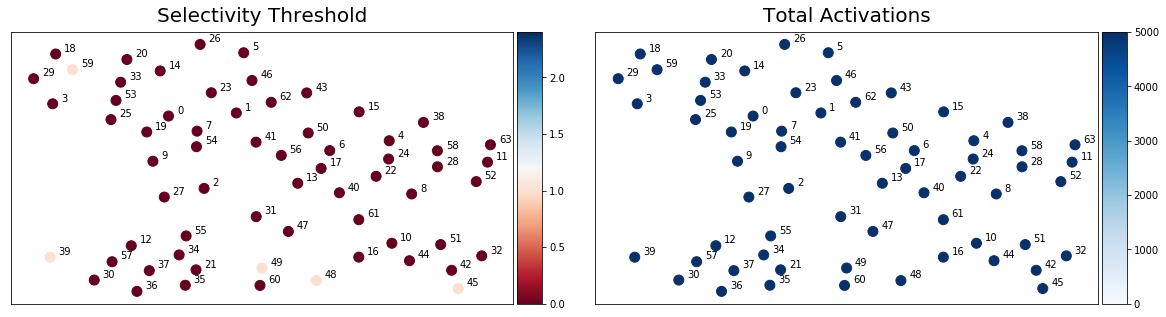

In [35]:
# Plot the class histogram projection using piecharts to display the 4 most predominant classes.
plot_projection_piechart(projection, histograms, 4, labels, '6th conv', 0.75, 500)

# Plot the same projection using entropy and total activations to color datapoints.
plot_auxiliar_projection(projection, selec_thresholds, activations, labels, 0.75)

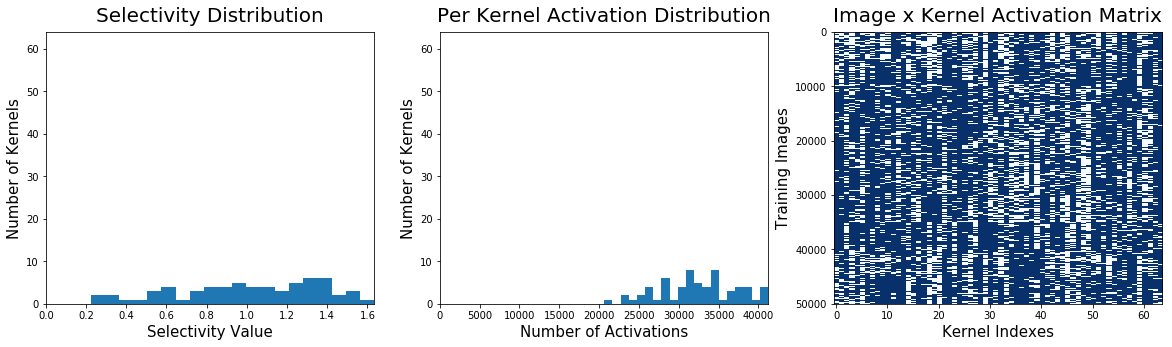

In [36]:
# Plot auxiliar histograms.
plot_auxiliar_visualizations(selectivity_values, activations, actv_matrix)

In [37]:
# Number of training images which do not activate in any kernel.
unactivated_elements_size(actv_matrix)

0

* When subtracting the negative activation elements from the bin, even when using V1 we can get significant predominance in the visualization of the 6th layer.
* The selectivity value of each kernel varies a lot. So it's likely this is a better metric to decide between two or more kernels.
* The per kernel activation histogram also display a high distribution.
* Again, every image in the training set activates in at least one kernel.

## Class Histograms - V2

One histogram per kernel, with each bin measuring the total number of positively valued pixels in the output activation from all images of that class.

### 1st Layer

In [38]:
# Calculate class histograms of each of the layer's kernels.
histograms, selectivity = class_histogram_conv2d_v2(model, 0, x_train, t_labels, p_labels, num_classes)

In [39]:
# Calculate the activation matrix of each training element.
actv_matrix = activation_matrix_conv2d(model, 0, x_train, t_labels, p_labels, num_classes)    

In [40]:
# Calculate which neurons are off the limits defined by the selectivity thresholds.
selec_thresholds = check_selectivity_threshold(selectivity)

# Get the selectivity value of each kernel.
selectivity_values = get_kernel_selectivity_value(selectivity)

In [41]:
# Get the number of elements in the training set activating positive values on each kernel.
activations = layer_activation_number(actv_matrix, t_labels, p_labels, num_classes)

In [42]:
# Project the layer's class histograms to bidimensional space.
projection, divergence = project_histogram(histograms, p=20)
print(projection.shape, divergence)

(64, 2) 0.18496814370155334


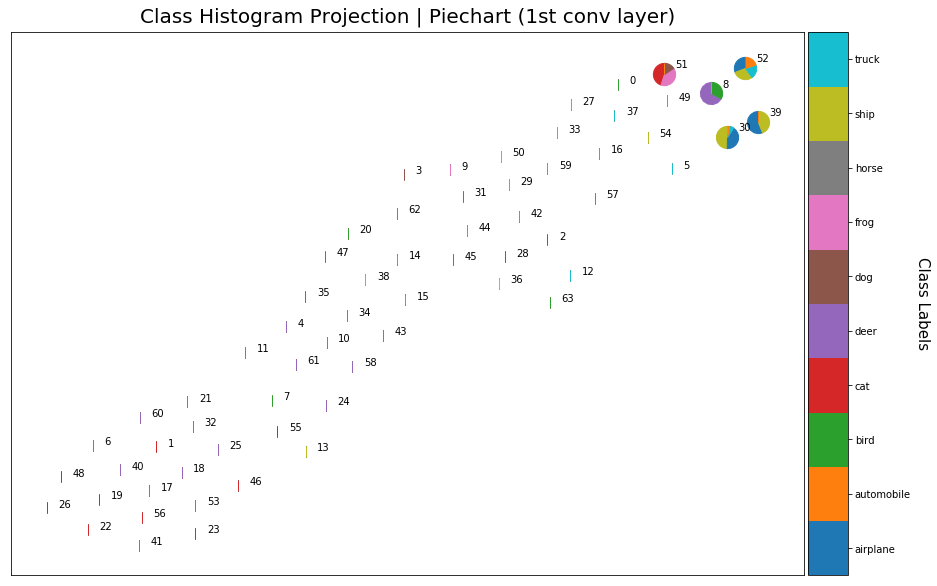

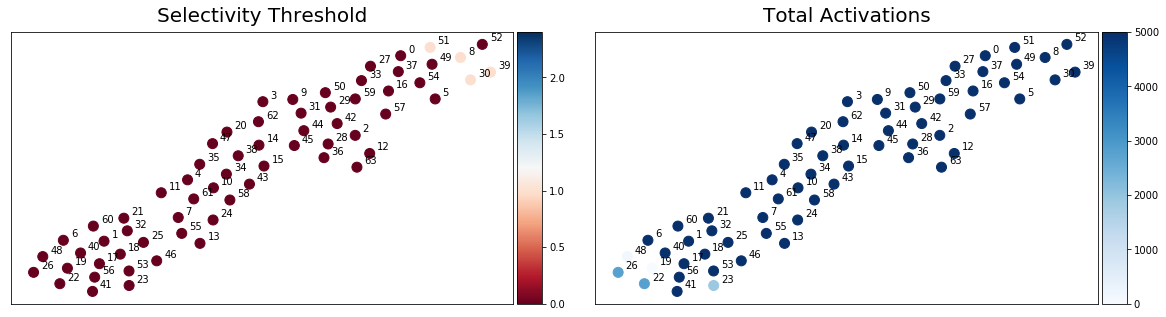

In [43]:
# Plot the class histogram projection using piecharts to display the 4 most predominant classes.
plot_projection_piechart(projection, histograms, 4, labels, '1st conv', 2.5, 500)

# Plot the same projection using entropy and total activations to color datapoints.
plot_auxiliar_projection(projection, selec_thresholds, activations, labels, 2.5)

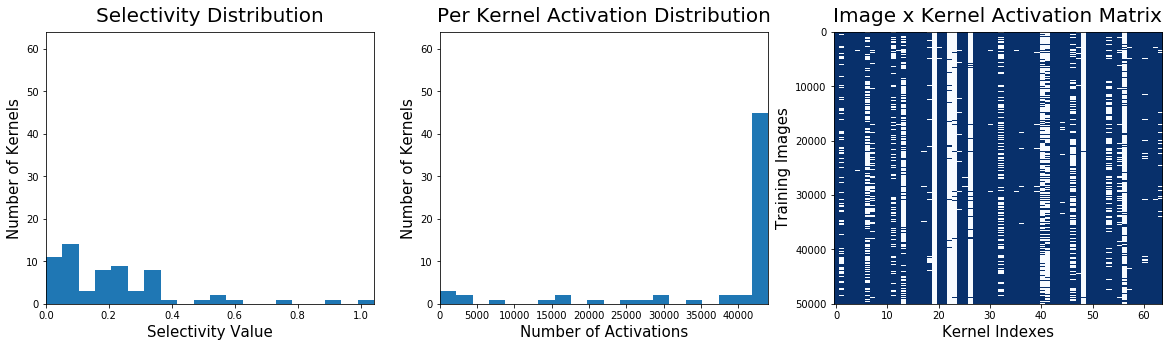

In [44]:
# Plot auxiliar histograms.
plot_auxiliar_visualizations(selectivity_values, activations, actv_matrix)

In [45]:
# Number of training images which do not activate in any kernel.
unactivated_elements_size(actv_matrix)

0

* V2 seems to not be viable anymore when subtracting the number of negative activations from the class histogram bins, as it is much more likely to output negative bins.

### 6th Layer

In [46]:
# Calculate class histograms of each of the layer's kernels.
histograms, selectivity = class_histogram_conv2d_v2(model, 9, x_train, t_labels, p_labels, num_classes)

In [47]:
# Calculate the activation matrix of each training element.
actv_matrix = activation_matrix_conv2d(model, 9, x_train, t_labels, p_labels, num_classes)    

In [48]:
# Calculate which neurons are off the limits defined by the selectivity thresholds.
selec_thresholds = check_selectivity_threshold(selectivity)

# Get the selectivity value of each kernel.
selectivity_values = get_kernel_selectivity_value(selectivity)

In [49]:
# Get the number of elements in the training set activating positive values on each kernel.
activations = layer_activation_number(actv_matrix, t_labels, p_labels, num_classes)

In [50]:
# Project the layer's class histograms to bidimensional space.
projection, divergence = project_histogram(histograms, p=20)
print(projection.shape, divergence)

(64, 2) 0.37063780426979065


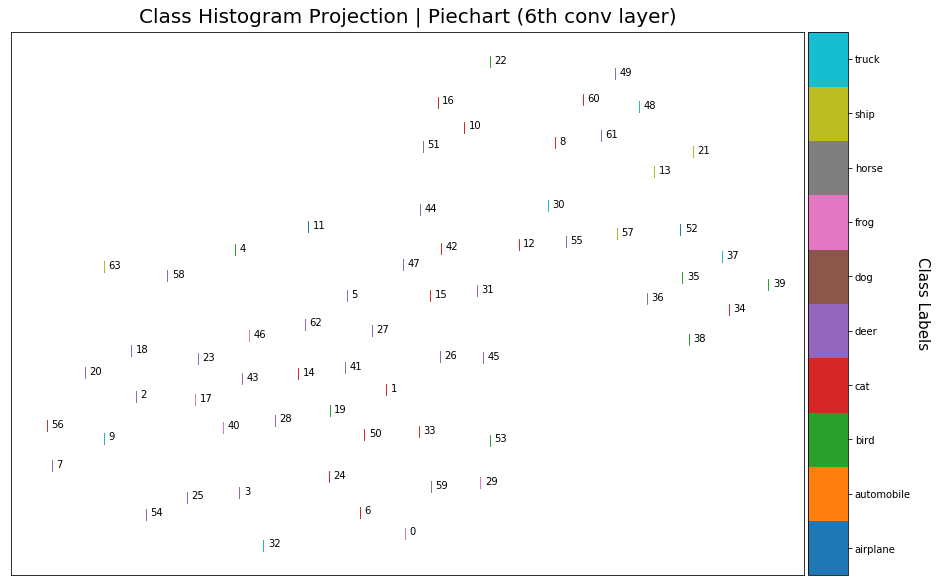

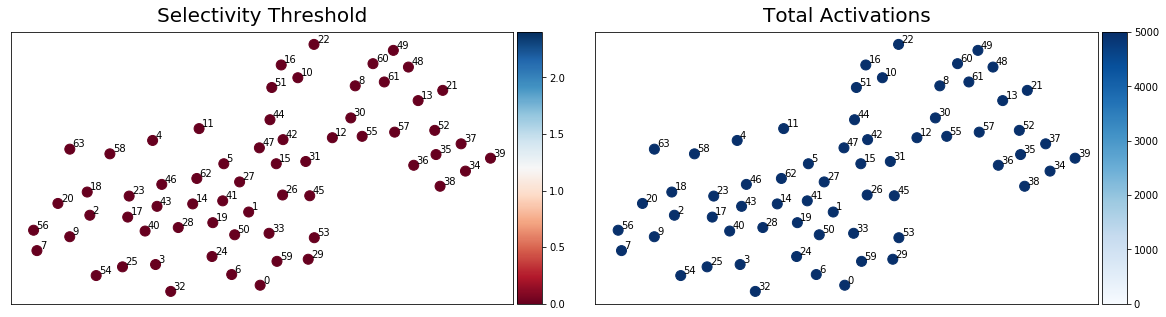

In [51]:
# Plot the class histogram projection using piecharts to display the 4 most predominant classes.
plot_projection_piechart(projection, histograms, 4, labels, '6th conv', 0.75, 500)

# Plot the same projection using entropy and total activations to color datapoints.
plot_auxiliar_projection(projection, selec_thresholds, activations, labels, 0.75)

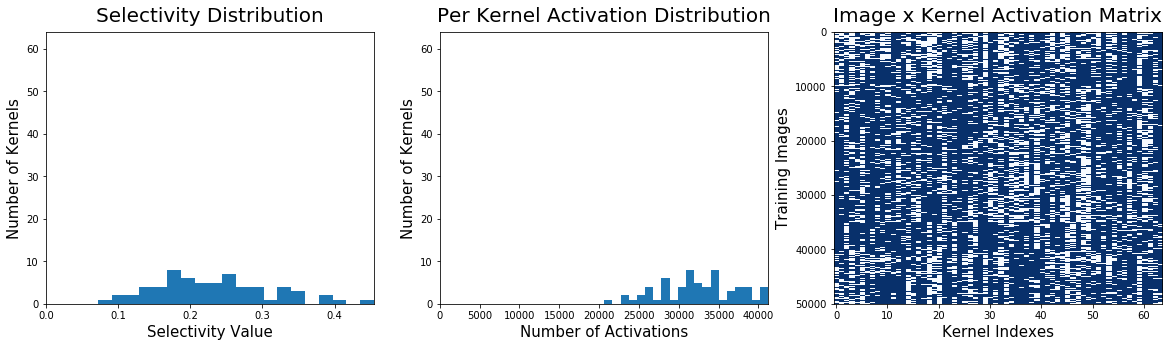

In [52]:
# Plot auxiliar histograms.
plot_auxiliar_visualizations(selectivity_values, activations, actv_matrix)

In [53]:
# Number of training images which do not activate in any kernel.
unactivated_elements_size(actv_matrix)

0

* Again, V2 is not suitable for the new class histogram calculation.

## Class Histograms - V3

One histogram per output pixel, with each bin measuring the total number of images from a particular class activating a positive value on that pixel.

### 1st Layer

In [80]:
# Calculate class histograms of each of the layer's kernels.
histograms, selectivity = class_histogram_conv2d_v3(model, 0, x_train, t_labels, p_labels, num_classes)

In [81]:
# Calculate the activation matrix of each training element.
actv_matrix = activation_matrix_conv2d(model, 0, x_train, t_labels, p_labels, num_classes)    

In [82]:
# Matrix shape.
histograms.shape, selectivity.shape

((32, 32, 64, 10), (32, 32, 64, 10))

In [83]:
# Reshape matrix.
histograms = histograms.reshape((histograms.shape[0]*histograms.shape[1], histograms.shape[2], num_classes))
selectivity = selectivity.reshape((selectivity.shape[0]*selectivity.shape[1]*selectivity.shape[2], num_classes))

In [84]:
# Matrix shape.
histograms.shape, selectivity.shape

((1024, 64, 10), (65536, 10))

In [85]:
# Cluster histograms.
hist_centers = cluster_histograms(histograms, num_classes)

In [86]:
# Matrix shape.
hist_centers.shape

(640, 10)

In [87]:
# Calculate which neurons are off the limits defined by the selectivity thresholds.
selec_thresholds = check_selectivity_threshold(selectivity)

# Get the selectivity value of each kernel.
selectivity_values = get_kernel_selectivity_value(selectivity)

In [88]:
# Get the number of elements in the training set activating positive values on each kernel.
activations = layer_activation_number(actv_matrix, t_labels, p_labels, num_classes)

In [89]:
# Project the layer's class histograms to bidimensional space.
projection, divergence = project_histogram(hist_centers, p=50)
print(projection.shape, divergence)

(640, 2) 0.3570359945297241


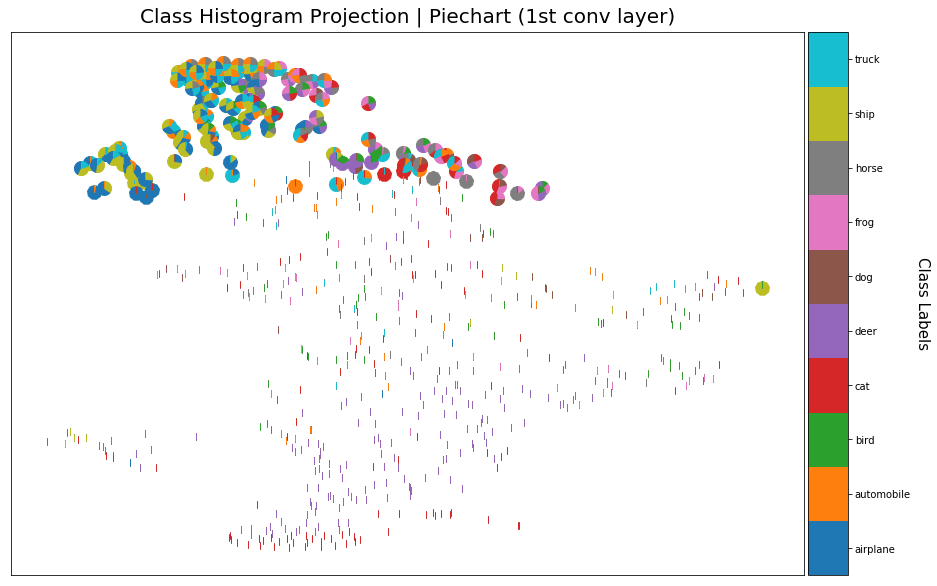

In [90]:
# Plot the class histogram projection using piecharts to display the 4 most predominant classes.
plot_projection_piechart(projection, hist_centers, 4, labels, '1st conv', -1, 200)

# Plot the same projection using entropy and total activations to color datapoints.
# plot_auxiliar_projection(projection, selec_thresholds, activations, labels, -1)

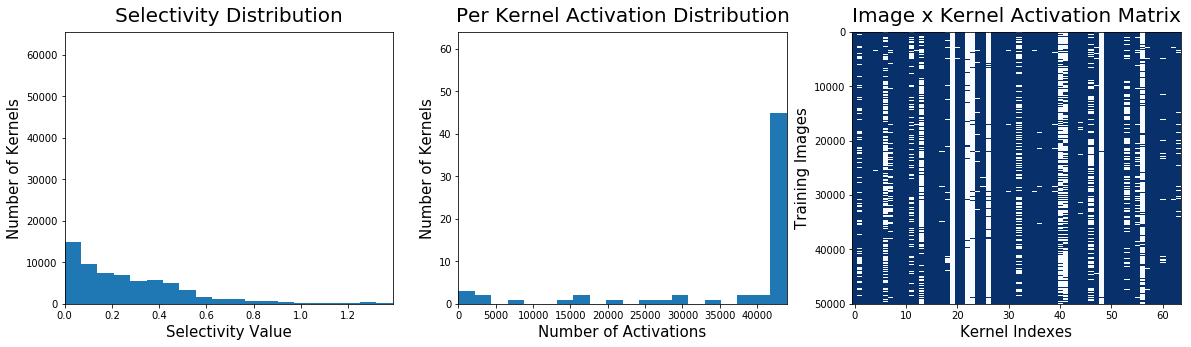

In [91]:
# Plot auxiliar histograms.
plot_auxiliar_visualizations(selectivity_values, activations, actv_matrix)

In [92]:
# Number of training images which do not activate in any kernel.
unactivated_elements_size(actv_matrix)

0

* We chose 10 clusters per kernel because that is the number of classes. So the projections displays 640 clusters of pixels (10 per kernel).
* Each cluster is represented by its mean value.
* Again, we have the problem of many pixel groups having negative bins as the most predominant ones. But maybe in this case those are the ones we can drop out from the model.
* Despite that, the pixel clusters with positive bins have clearly predominant classes.
* I did not display the selectivity threshold of each datapoint because I'm not sure how to compute a meaningful selectivity value for the mean of a cluster of histograms. But we know for sure that all the datapoints with empty piecharts would be dropped out by the threshold.
* Again, different pixel groups display different levels of selectivity, which is good to pick the best among them.
* Every image in the training set activates in at least one kernel.

### 6th Layer

In [93]:
# Calculate class histograms of each of the layer's kernels.
histograms, selectivity = class_histogram_conv2d_v3(model, 9, x_train, t_labels, p_labels, num_classes)

In [94]:
# Calculate the activation matrix of each training element.
actv_matrix = activation_matrix_conv2d(model, 9, x_train, t_labels, p_labels, num_classes)    

In [95]:
# Matrix shape.
histograms.shape, selectivity.shape

((8, 8, 64, 10), (8, 8, 64, 10))

In [96]:
# Reshape matrix.
histograms = histograms.reshape((histograms.shape[0]*histograms.shape[1], histograms.shape[2], num_classes))
selectivity = selectivity.reshape((selectivity.shape[0]*selectivity.shape[1]*selectivity.shape[2], num_classes))

In [97]:
# Matrix shape.
histograms.shape, selectivity.shape

((64, 64, 10), (4096, 10))

In [98]:
# Cluster histograms.
hist_centers = cluster_histograms(histograms, num_classes)

In [99]:
# Matrix shape.
hist_centers.shape

(640, 10)

In [100]:
# Calculate which neurons are off the limits defined by the selectivity thresholds.
selec_thresholds = check_selectivity_threshold(selectivity)

# Get the selectivity value of each kernel.
selectivity_values = get_kernel_selectivity_value(selectivity)

In [101]:
# Get the number of elements in the training set activating positive values on each kernel.
activations = layer_activation_number(actv_matrix, t_labels, p_labels, num_classes)

In [102]:
# Project the layer's class histograms to bidimensional space.
projection, divergence = project_histogram(hist_centers, p=50)
print(projection.shape, divergence)

(640, 2) 0.7376676201820374


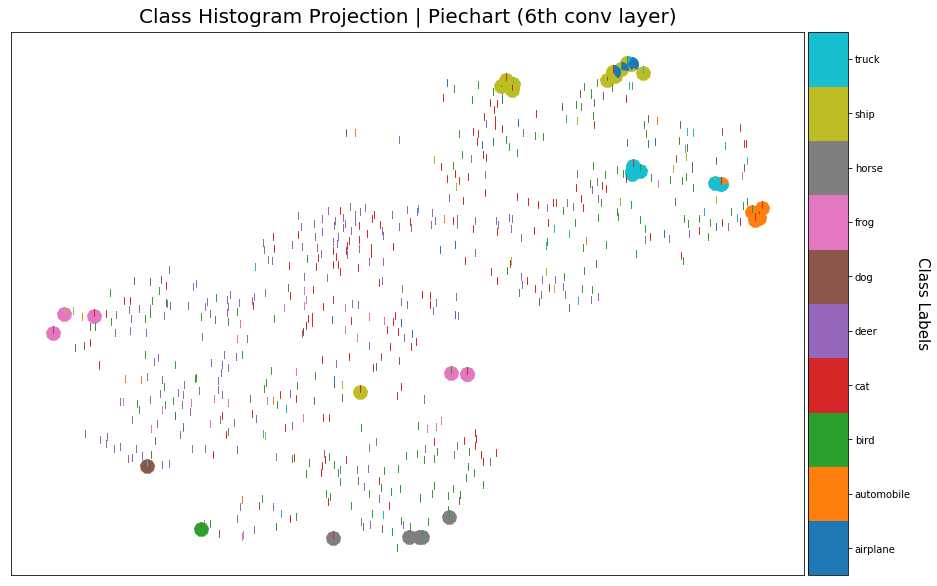

In [103]:
# Plot the class histogram projection using piecharts to display the 4 most predominant classes.
plot_projection_piechart(projection, hist_centers, 4, labels, '6th conv', -1, 200)

# Plot the same projection using entropy and total activations to color datapoints.
# plot_auxiliar_projection(projection, selec_thresholds, activations, labels, -1)

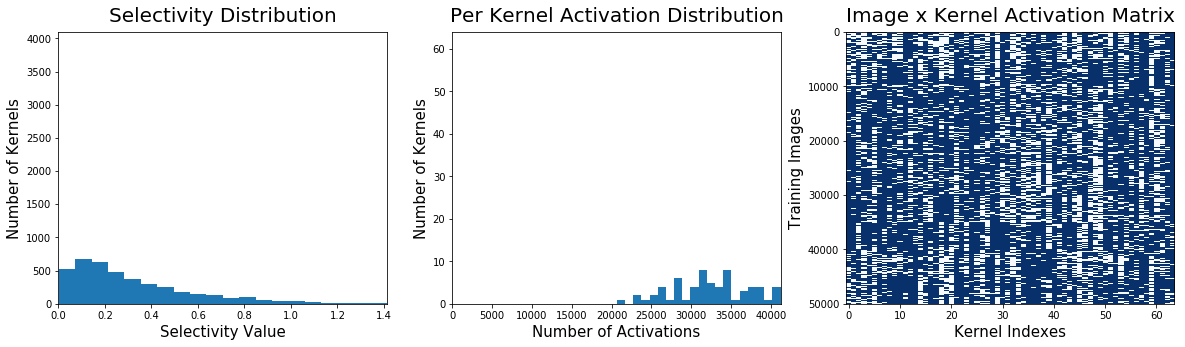

In [104]:
# Plot auxiliar histograms.
plot_auxiliar_visualizations(selectivity_values, activations, actv_matrix)

In [105]:
# Number of training images which do not activate in any kernel.
unactivated_elements_size(actv_matrix)

0

* We chose 10 clusters per kernel because that is the number of classes. So the projections displays 640 clusters of pixels (10 per kernel).
* Each cluster is represented by its mean value.
* In this layer, the problem of many pixel groups having negative bins as the most predominant ones is aggraveted.
* Although is interesting to notice that most of the pixel groups that do not have this problem have an almost completely predominant class.
* I did not display the selectivity threshold of each datapoint because I'm not sure how to compute a meaningful selectivity value for the mean of a cluster of histograms. But we know for sure that all the datapoints with empty piecharts would be dropped out by the threshold.
* Again, different pixel groups display different levels of selectivity, which is good to pick the best among them.
* Every image in the training set activates in at least one kernel.

## Conclusions

* With this new approach for building class histograms, V1 seems to become viable again. Some kernels in the sixth layer do have predominant class(es).
* V3 and particularly V2 techniques end up generating many class histograms with only negative bins. These would be cut off by the threshold. The kernels/pixel groups who don't fall in this problem display very predominant classes though.

## Functions

In [5]:
# Calculate activation vectors in the l-th layer.
def layer_activation(model, l, dataset):
    p_model = Sequential()
    
    for i in range(l+1):
        p_model.add(model.layers[i])
    
    activations = p_model.predict(dataset)
    
    return activations

In [6]:
# Build class histograms of a dense layer's units.
def class_histogram_dense(model, layer, x_train, t_labels, p_labels, num_classes):
    num_units = model.layers[layer].output_shape[-1]
    
    # Build the histogram.
    histograms = np.zeros((num_units, num_classes))
    
    # Only consider activations produced by correctly classified elements.
    x_train = x_train[t_labels == p_labels]
    t_labels = t_labels[t_labels == p_labels]
    
    # Calculate activation of observations for every c class.
    for c in range(num_classes):
        # Activations produced by elements of class c.
        a = layer_activation(model, layer, x_train[t_labels == c])
        
        # Calculate the size of c-th bin for every unit.
        for u in range(num_units):
            b = a[:, u]
            histograms[u, c] = b[b > 0.0].shape[0]
    
    return histograms

In [7]:
# Build matrix mapping training elements to kernels whose activate for them.
def activation_matrix_conv2d(model, layer, x_train, t_labels, p_labels, num_classes):
    # Matrix dimensions.
    num_units = model.layers[layer].output_shape[-1]
    num_elems = x_train.shape[0]
    
    # Build matrix.
    matrix = np.zeros((num_elems, num_units))
    
    # Calculate activation of elements from each c class.
    i = 0
    for c in range(num_classes):        
        # Activations produced by elements of class c.
        a = layer_activation(model, layer, x_train[t_labels == c])
        
        # Calculate the size of c-th bin for every unit.
        for u in range(num_units):
            # Fill the matrix with 1 if positive activation or 0 otherwise.
            b = np.max(a[:, :, :, u], axis=(1, 2))
            b = (b > 0.0).astype(int)
            matrix[i:i+b.shape[0], u] = b
            
        i += b.shape[0]
    
    return matrix

In [8]:
# Returns the number of training examples which do not activate for any kernel.
def unactivated_elements_size(matrix):
    m = np.max(matrix, axis=1)
    return m[m == 0.0].shape[0]

In [9]:
# Build class histograms. Each bin represents the number of images which activates for that kernel.
def class_histogram_conv2d_v1(model, layer, x_train, t_labels, p_labels, num_classes):
    num_units = model.layers[layer].output_shape[-1]
        
    # Build the histogram.
    histograms = np.zeros((num_units, num_classes))
    selectivity = np.zeros((num_units, num_classes))
    
    # Only consider activations produced by correctly classified elements.
    x_train = x_train[t_labels == p_labels]
    t_labels = t_labels[t_labels == p_labels]
    
    # Calculate activation of observations for every c class.
    for c in range(num_classes):        
        # Activations produced by elements of class c.
        a = layer_activation(model, layer, x_train[t_labels == c])
        
        # Calculate the size of c-th bin for every unit.
        for u in range(num_units):
            # We only care about the pixel with maximum activation value in the unit kernel.
            b = np.max(a[:, :, :, u], axis=(1, 2))
            histograms[u, c] = b[b > 0.0].shape[0] - b[b == 0.0].shape[0]
            
            # Compute the selectivity of the kernel.
            selectivity[u, c] = histograms[u, c] / b.shape[0]
        
    return histograms, selectivity

In [10]:
# Build class histograms, measuring the number of positive pixels each class produced.
def class_histogram_conv2d_v2(model, layer, x_train, t_labels, p_labels, num_classes):
    num_units = model.layers[layer].output_shape[-1]
    
    # Build the histogram.
    histograms = np.zeros((num_units, num_classes))
    selectivity = np.zeros((num_units, num_classes))
    
    # Only consider activations produced by correctly classified elements.
    x_train = x_train[t_labels == p_labels]
    t_labels = t_labels[t_labels == p_labels]
    
    # Calculate activations of observation pixels for every c class.
    for c in range(num_classes):
        # Activations produced by elements of class c.
        a = layer_activation(model, layer, x_train[t_labels == c])
        
        # Calculate the size of c-th bin for every unit.
        for u in range(num_units):
            # We want the number of individual pixels with positive activations.
            b = a[:, :, :, u].reshape((a.shape[0]*a.shape[1]*a.shape[2],))
            histograms[u, c] = b[b > 0.0].shape[0] - b[b == 0.0].shape[0]
            
            # Compute the selectivity of the kernel.
            selectivity[u, c] = histograms[u, c] / b.shape[0]
            
    return histograms, selectivity

In [11]:
# Build class histograms for every pixel in the output of a conv2d layer.
def class_histogram_conv2d_v3(model, layer, x_train, t_labels, p_labels, num_classes):
    width = model.layers[layer].output_shape[1]
    height = model.layers[layer].output_shape[2]
    units = model.layers[layer].output_shape[3]
    
    # Build the histogram.
    histograms = np.zeros((width, height, units, num_classes))
    selectivity = np.zeros((width, height, units, num_classes))
    
    # Only consider activations produced by correctly classified elements.
    x_train = x_train[t_labels == p_labels]
    t_labels = t_labels[t_labels == p_labels]
    
    # Calculate how many observations from class c activate positive values for each pixel in the layer's output.
    for c in range(num_classes):
        # Activations produced by elements of class c.
        a = layer_activation(model, layer, x_train[t_labels == c])
        
        # Calculate the size of c-th bin for every pixel in the layer's output.
        for u in range(units):
            for h in range(height):
                for w in range(width):
                    b = a[:, w, h, u]
                    histograms[w, h, u, c] = b[b > 0.0].shape[0] - b[b == 0.0].shape[0]
                    
                    # Compute the selectivity of the kernel.
                    selectivity[w, h, u, c] = histograms[w, h, u, c] / b.shape[0]
        
    return histograms, selectivity

In [12]:
# Project a set of class histograms to bidimensional space using t-SNE.
def project_histogram(histograms, p=30, e=12.0, l=200.0):
    tsne = TSNE(perplexity=p, early_exaggeration=e, learning_rate=l).fit(histograms)
    projection = tsne.embedding_
    
    return projection, tsne.kl_divergence_

In [13]:
# Return how many observations activated in each unit.
def layer_activation_number(actv_matrix, t_labels, p_labels, num_classes):
    # Number of units.
    actv_amount = np.zeros((actv_matrix.shape[1]))
    
    # Calculate the number of activations per pixels for images of each class.
    i = 0
    for c in range(num_classes):
        # Get the labels true and predicted from c class.
        t = t_labels[t_labels == c]
        p = p_labels[t_labels == c]
        
        # Get the submatrix containing only correctly classified elements from c class.
        m = actv_matrix[i:i+t.shape[0], :][t == p]
        
        # Increase the number of elements according to matrix.
        actv_amount = actv_amount + np.sum(m, axis=0)
        
        # Update index.
        i += t.shape[0]
        
    return actv_amount

In [14]:
# Check if the selectivity vector of each kernel respects both thresholds.
def check_selectivity_threshold(selectivity):
    selec_threshold = np.zeros((selectivity.shape[0],))
        
    for i in range(selectivity.shape[0]):
        # Check if the number of positive selectivity is no more than half the number of classes.
        perc_threshold = int(selectivity[i, selectivity[i, :] > 0.0].shape[0] <= selectivity[i, :].shape[0]/2)
        
        # Check if the max threshold is positive.
        max_s_threshold = int(np.max(selectivity[i, :]) > 0.0)
        
        # If one of the thresholds is not respected, returns 0. Otherwise 1.
        selec_threshold[i] = perc_threshold * max_s_threshold
    
    return selec_threshold

In [15]:
# Returns a vector containing the selectivity value of each kernel.
def get_kernel_selectivity_value(selectivity):
    # Get the max and min selectivity value of each kernel.
    selec_max = np.max(selectivity, axis=1)
    selec_min = np.min(selectivity, axis=1)
    
    # Returns the difference between max and min value.
    return selec_max - selec_min

In [16]:
# Cluster the histograms of each kernel in C clusters, return a dataset with all the 10*K cluster centers.
def cluster_histograms(histograms, num_classes):
    hist_centers = np.zeros((histograms.shape[1]*num_classes, histograms.shape[2]))

    for k in range(histograms.shape[1]):
        kmeans = KMeans(num_classes).fit(histograms[:, k, :])
        hist_centers[k*num_classes:(k+1)*num_classes, :] = kmeans.cluster_centers_
        
    return hist_centers

In [17]:
# Plot the class histogram projection using pie-charts to represent each unit/datapoint.
def plot_projection_piechart(projection, histograms, n, labels, l_type, offset, size):
    f, ax = plt.subplots(figsize=(15, 10))

    # Transform histogram data into pie chart.
    h = np.zeros((histograms.shape[0], n))
    c = np.zeros((histograms.shape[0], n)).astype(int)
    
    for i in range(h.shape[0]):
        c[i, :] = np.argsort(histograms[i, :])[::-1][:n]
        h[i, :] = histograms[i, c[i, :]]
        h[i, :] = np.maximum(h[i, :], np.zeros((h.shape[1],)))
        
        s = np.sum(h[i, :])
        if s > 0:
            h[i, :] /= s
        
        for j in range(1, h.shape[1]):
            h[i, j] += h[i, j-1]

    # Plot piecharts.
    for i in range(h.shape[0]):
        for j in range(h.shape[1]):
            if j == 0:
                a = np.pi/2
            else:
                a = np.pi/2 + 2*np.pi*h[i, j-1]

            b = np.pi/2 + 2*np.pi*h[i, j]

            x = [0] + np.cos(np.linspace(a, b, 10)).tolist()
            y = [0] + np.sin(np.linspace(a, b, 10)).tolist()
            xy = np.column_stack([x, y])

            ax.scatter(projection[i, 0], projection[i, 1], marker=(xy, 0), s=size, c=cm.tab10(c[i, j]))
        
    # Plot unit indexes.
    if offset > 0.0:
        for i, p in enumerate(projection):
            ax.annotate(str(i), (p[0] + offset, p[1] + offset))
    
    # Plot the colorbar.
    cax = make_axes_locatable(ax).append_axes("right", size="5%", pad=0.05)
    cbar = ColorbarBase(cax, cmap=cm.tab10, ticks=[i/10.0 + 0.05 for i in range(10)])    
    cbar.ax.set_yticklabels(labels)
    cbar.ax.set_ylabel("Class Labels", rotation=-90, va="bottom", fontsize=15)

    # Set titles.
    ax.set_title('Class Histogram Projection | Piechart (' + l_type + ' layer)', fontsize=20, pad=10)

    # Remove ticks
    ax.set_xticks([])
    ax.set_yticks([])
    
    plt.show()

In [18]:
# Plot the class histogram projection coloring units (datapoints) by the histogram selectivity thresholds
# and total activations.
def plot_auxiliar_projection(projection, thresholds, activations, labels, offset):
    f, (ax1, ax2) = plt.subplots(ncols=2, figsize=(20, 5), gridspec_kw={"width_ratios": [1, 1]})
    plt.subplots_adjust(wspace=0.1)
    
    # Plot points on the selectivity thresholds scatterplot.
    im = ax1.scatter(projection[:, 0], projection[:, 1], c=thresholds, cmap=cm.RdBu, s=100, vmin=0.0, vmax=2.4)
    
    # Plot unit indexes.
    if offset > 0.0:
        for i, p in enumerate(projection):
            ax1.annotate(str(i), (p[0] + offset, p[1] + offset))
        
    # Plot the colorbar.
    cax1 = make_axes_locatable(ax1).append_axes("right", size="5%", pad=0.05)
    cbar = f.colorbar(im, cax=cax1)
        
    # Plot points on the activation scatterplot.
    im = ax2.scatter(projection[:, 0], projection[:, 1], c=activations, cmap=cm.Blues, s=100, vmin=0.0, vmax=5000)
    
    # Plot unit indexes.
    if offset > 0.0:
        for i, p in enumerate(projection):
            ax2.annotate(str(i), (p[0] + offset, p[1] + offset))
        
    # Plot the colorbar.
    cax2 = make_axes_locatable(ax2).append_axes("right", size="5%", pad=0.05)
    cbar = f.colorbar(im, cax=cax2)
    
    # Set titles.
    ax1.set_title('Selectivity Threshold', fontsize=20, pad=10)
    ax2.set_title('Total Activations', fontsize=20, pad=10)
    
    # Remove ticks
    ax1.set_xticks([])
    ax1.set_yticks([])
    ax2.set_xticks([])
    ax2.set_yticks([])

    plt.show()

In [19]:
# Plot one histogram with the selectivity distribution, another histogram with the activation number distribution
# and the heatmap matrix of each training element x kernel pair.
def plot_auxiliar_visualizations(selectivity_values, activations, actv_matrix):
    f, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize=(20, 5), gridspec_kw={"width_ratios": [1, 1, 1]})
    
    # Selectivity Distribution.
    ax1.hist(selectivity_values, 20)
    ax1.axis([0, np.max(selectivity_values), 0, selectivity_values.shape[0]])
    
    # Activation Distribution.
    ax2.hist(activations, 20)
    ax2.axis([0, np.max(activations), 0, activations.shape[0]])
    
    # Activation Matrix.
    ax3.imshow(actv_matrix, aspect='auto', cmap=cm.Blues)
    
    # Set titles.
    ax1.set_title('Selectivity Distribution', fontsize=20, pad=10)
    ax2.set_title('Per Kernel Activation Distribution', fontsize=20, pad=10)
    ax3.set_title('Image x Kernel Activation Matrix', fontsize=20, pad=10)
    
    # Set axis labels
    ax1.set_xlabel('Selectivity Value', fontsize=15)
    ax1.set_ylabel('Number of Kernels', fontsize=15)
    ax2.set_xlabel('Number of Activations', fontsize=15)
    ax2.set_ylabel('Number of Kernels', fontsize=15)
    ax3.set_xlabel('Kernel Indexes', fontsize=15)
    ax3.set_ylabel('Training Images', fontsize=15)
    
    plt.show()